In [1]:
# This cell only for package version control
import sys
import qiskit
import numpy
import matplotlib
print('python    :', sys.version)
print('qiskit    :',qiskit.__version__, qiskit.__qiskit_version__)
print('numpy     :',numpy.__version__)
print('matplotlib:',matplotlib.__version__)

python    : 3.8.8 | packaged by conda-forge | (default, Feb 20 2021, 16:22:27) 
[GCC 9.3.0]
qiskit    : 0.17.1 {'qiskit-terra': '0.17.1', 'qiskit-aer': '0.8.1', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.12.3', 'qiskit-aqua': '0.9.1', 'qiskit': '0.25.2', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}
numpy     : 1.20.2
matplotlib: 3.3.4


So far you mastered the notation of quantum mechanics and quantum computing, understood as much physics as needed to perform various operations on quantum states, and now you are ready to build quantum algorithms. In this notebook, we look at the basics of gate-model quantum computing, which is sometimes also referred to as universal quantum computing. Most academic and commercial efforts to build a quantum computer focus on this model: Alibaba, Baidu, Google, HP, IBM Q, Intel, IonQ, Microsoft, Rigetti Computing, and Tencent all aim at this, and the list keeps expanding. It remains unclear which implementation will prove scalable: superconducting chips, photonic systems, and ion traps are the most common types, each having its own advantages and disadvantages. We abstract away, we focus on the quantum algorithms irrespective of the physical implementation.

To get there, first we have to familiarize ourselves with some gates and what happens to those gates on quantum computers. The following diagram shows the software stack that bridges a problem we want to solve with the actual computational back-end [[1](#1)]:

<img src="../figures/universal_quantum_workflow.png" alt="Software stack on a gate-model quantum computer" style="width: 400px;"/>

First, we define the problem at a high-level and a suitable quantum algorithm is chosen. Then, we express the quantum algorithm as a quantum circuit composed of gates. This in turn has to be compiled to a specific quantum gate set available. The last step is to execute the final circuit either on a quantum processor or on a simulator.

The quantum algorithms we are interested in are about machine learning. In this notebook, we look at the levels below algorithms: the definition of circuits, their compilation, and the mapping to the hardware or a simulator.


# Defining circuits

Circuits are composed of qubit registers, gates acting on them, and measurements on the registers. To store the outcome of registers, many quantum computing libraries add classical registers to the circuits. Even by this language, you can tell that this is a very low level of programming a computer. It resembles the assembly language of digital computers, in which a program consists of machine code instructions.

Qubit registers are indexed from 0. We often just say qubit 0, qubit 1, and so on, to refer to the register containing a qubit. This is not to be confused with the actual state of the qubit, which can be $|0\rangle$, $|1\rangle$, or any superposition thereof. For instance, qubit 0 can be in the state $|1\rangle$.

Let's take a look at the gates. In digital computing, a processor transforms bit strings to bit strings with logical gates. Any bit string can be achieved with just two gates, which makes universal computations possible with simple operations composed only of these two types of gates. It is remarkable and surprising that the same is also true for quantum computers: any unitary operation can be decomposed into elementary gates, and three types of gates are sufficient. This is remarkable since we are talking about transforming continuous-valued probability amplitudes, not just discrete elements. Yet, this result is what provides the high-level theoretical foundation for being able to build a universal quantum computer at all.

Let's look at some common gates, some of which we have already seen. Naturally, all of these are unitary.

| Gate |Name                | &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Matrix |
|------|--------------------|---------------------------------------------------------------------|
|   X  | Pauli-X or NOT gate|$\begin{bmatrix}0 & 1\\ 1& 0\end{bmatrix}$|
|   Z  | Pauli-Z  gate      |$\begin{bmatrix}1 & 0\\ 0& -1\end{bmatrix}$|
|  H   | Hadamard gate      |$\frac{1}{\sqrt{2}}\begin{bmatrix}1 & 1\\ 1& -1\end{bmatrix}$|
| Rx($\theta$)| Rotation around X|$\begin{bmatrix}\cos(\theta/2) & -i \sin(\theta/2)\\ -i \sin(\theta / 2) & \cos(\theta / 2)\end{bmatrix}$|
| Ry($\theta$)| Rotation around Y|$\begin{bmatrix}\cos(\theta/2) & -\sin(\theta/2)\\ \sin(\theta / 2) & \cos(\theta / 2)\end{bmatrix}$|
| CNOT, CX | Controlled-NOT | $\begin{bmatrix}1 & 0 & 0 &0\\ 0 & 1 & 0 &0\\ 0 & 0 & 0 &1\\ 0 & 0 & 1 &0\end{bmatrix}$|

As we have seen before, the rotations correspond to axis defined in the Bloch sphere. 

There should be one thing immediately apparent from the table: there are many, in fact, infinitely many single-qubit operations. The rotations, for instance, are parametrized by a continuous value. This is in stark contrast with digital circuits, where the only non-trivial single-bit gate is the NOT gate.

The CNOT gate is the only two-qubit gate in this list. It has a special role: we need two-qubit interactions to create entanglement. Let's repeat the circuit for creating the $|\phi^+\rangle = \frac{1}{\sqrt{2}}(|00\rangle+|11\rangle)$. We will have two qubit registers and two classical registers for measurement output. First, let's define the circuit and plot it:

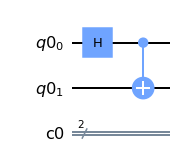

In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute
from qiskit import Aer
from qiskit.tools.visualization import circuit_drawer, plot_histogram

q = QuantumRegister(2)
c = ClassicalRegister(2)
circuit = QuantumCircuit(q, c)
circuit.h(q[0])
circuit.cx(q[0], q[1])
circuit_drawer(circuit, output = 'mpl' )

Note that we can't just initialize the qubit registers in a state we fancy. All registers are initialized in $|0\rangle$ and creating a desired state is **part** of the circuit. In a sense, arbitrary state preparation is the same as universal quantum computation: the end of the calculation is a state that we desired to prepare. Some states are easier to prepare than others. The above circuit has only two gates to prepare our target state, so it is considered very easy.

Let us see what happens in this circuit. The Hadamard gate prepares an equal superposition $\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$ in qubit 0. This qubit controls an X gate on qubit 1. Since qubit 0 is in the equal superposition after the Hadamard gate, it will not apply the X gate for the first part of the superposition ($|0\rangle$) and it will apply the X gate for the second part of the superposition ($|1\rangle$). Thus we create the final state $\frac{1}{\sqrt{2}}(|00\rangle+|11\rangle)$, and we entangle the two qubit registers.

A digital computer's processing unit typically has 64-bit registers and it is able to perform universal calculations on bit strings. Any complex calculation is broken down into elementary 64-bit operations, either sequentially or in parallel execution. So you may wonder what is the deal with the thousands of qubits we expect from a quantum computer. Why can't a 64-qubit quantum computer be enough?

Entanglement is the easiest way to understand why we need so many qubits. Entanglement is a key resource in quantum computing and we want to make use of it. If we have 64-qubits and we want to entangle another one outside these 64 registers, we would have get rid of the qubit in one of the registers, potentially destroying a superposition and definitely destroying entanglement between that register and any other qubit on the chip. The only way to make use of superpositions and the strong correlations provided by entanglement is if the entire problem is on the quantum processing unit for the duration of the calculation.

This global nature of the calculation is also the reason why there is a focus on problems that are difficult to break down into elementary calculations. The travelling salesman problem is a great example: we need to consider all cities and all distances to minimize overall travel length.

To finish off the circuit, we could add a measurement to each qubit:

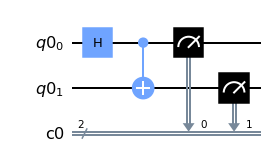

In [3]:
circuit.measure(q, c)
circuit_drawer(circuit, output = 'mpl')

Finally, we can plot the statistics:

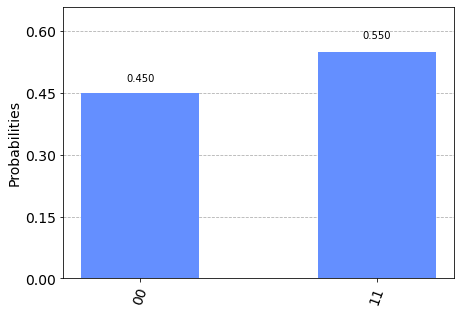

In [4]:
backend = Aer.get_backend('qasm_simulator')
job = execute(circuit, backend, shots=100)
plot_histogram(job.result().get_counts(circuit))

As we have seen before, 01 and 10 never appear.

# Compilation

The circuit is the way to describe a quantum algorithm. It may also contain some arbitrary single or two-qubit unitary and controlled versions thereof. A quantum compiler should be able to decompose these into elementary gates.

For instance, in Qiskit, you can get access to the general unitary using the $u3$ gate

$$
u3(\theta, \phi, \lambda) = \begin{pmatrix}
\cos(\theta/2) & -e^{i\lambda}\sin(\theta/2) \\
e^{i\phi}\sin(\theta/2) & e^{i\lambda+i\phi}\cos(\theta/2) 
\end{pmatrix}.
$$

The compiler decomposes it into an actual gate sequence.

This is one task of a quantum compiler. The next one is to translate the gates given in the circuit to the gates implemented in the hardware or the simulator. In the table above, we defined many gates, but a well-chosen set of three is sufficient for universality. For engineering constraints, typically one minimal set of universal gates is implemented in the hardware. It depends on the physical architecture which three.

At this point, the number of gates applied is probably already increasing: the decomposition of unitary will create many gates and the translation of gates is also likely to add more gates. An additional problem is the topology of the qubits: in some implementations not all qubit registers are connected to each other. The most popular implementation is superconducting qubits, which are manufactured on silicon chips just like any digital device you have. Since this is a quintessentially two dimensional layout, most qubits on the chip will not be connected. Here is an example topology of eight qubits on a superconducting quantum computer:

<img src="../figures/eight_qubits.svg" alt="8-qubit topology" style="width: 200px;"/>

If we want to perform a two-qubit operations between two qubits that are not neighbouring, we have to perform SWAP operations to switch the qubit states between registers. A SWAP consists of three CNOT gates in a sequence.

The total number of gates at the end of the compilation reflects the true requirement of the hardware. *Circuit depth* is the number of time steps required to execute the circuit, assuming that gates acting on distinct qubits can operate in parallel. On current and near-term quantum computers, we want circuits to be shallow, otherwise decoherence or other forms of noise destroy our calculations.

We have to emphasize that the compilation depends on the backend. On the simulator, physical constraints do not apply. If we compile the circuit above, its depth will not increase:

In [5]:
from qiskit.compiler import assemble
compiled_circuit = assemble(circuit, backend)
compiled_circuit.to_dict()['experiments'][0]['instructions']

[{'name': 'h', 'qubits': [0]},
 {'name': 'cx', 'qubits': [0, 1]},
 {'name': 'measure', 'qubits': [0], 'memory': [0]},
 {'name': 'measure', 'qubits': [1], 'memory': [1]}]

# References

[1] M. Fingerhuth, T. Babej, P. Wittek. (2018). [Open source software in quantum computing](https://doi.org/10.1371/journal.pone.0208561). *PLOS ONE* 13(12):e0208561.  <a id='1'></a>